### Working with distributed data

Let's see how to make some Data analisys on distributed dataset

In [1]:
from dask.distributed import Client, progress
client = Client(n_workers=2, threads_per_worker=2, memory_limit='2GB')
client

Client Scheduler: tcp://127.0.0.1:34715 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 2 Cores: 4 Memory: 4.00 GB


Let's create a random timeseries dataset with the following attributes:

+ It stores a record for every 10 seconds of the year 2000

+ It splits that year by month, keeping every month as a separate Pandas dataframe

+ Along with a datetime index it has columns for names, ids, and numeric values

This is a small dataset of about 480 MB. Increase the number of days or reduce the frequency to practice with a larger dataset.

In [2]:
import dask
import dask.dataframe as dd
df = dask.datasets.timeseries(start='2019-03-01', end='2019-04-30')

In [3]:
df

,id,name,x,y
npartitions=60,,,,
2019-03-01,int64,object,float64,float64
2019-03-02,...,...,...,...
...,...,...,...,...
2019-04-29,...,...,...,...
2019-04-30,...,...,...,...


In [4]:
df.dtypes

id        int64
name     object
x       float64
y       float64
dtype: object

In [5]:
import pandas as pd
pd.options.display.precision = 2
pd.options.display.max_rows = 10

In [6]:
df.head(3)

,id,name,x,y
timestamp,,,,
2019-03-01 00:00:00,962,Dan,0.59,0.26
2019-03-01 00:00:01,1045,Charlie,0.83,-0.48
2019-03-01 00:00:02,990,Hannah,0.14,-0.52


In [7]:
df2 = df[df.y > 0]
df3 = df2.groupby('name').x.std()
df3

/usr/local/lib/python2.7/dist-packages/dask/dataframe/utils.py:391: FutureWarning: Creating a DatetimeIndex by passing range endpoints is deprecated.  Use `pandas.date_range` instead.
  tz=idx.tz, name=idx.name)


Dask Series Structure:
npartitions=1
    float64
        ...
Name: x, dtype: float64
Dask Name: sqrt, 311 tasks

In [8]:
computed_df = df3.compute()
type(computed_df)

pandas.core.series.Series

In [9]:
computed_df

name
Alice      0.58
Bob        0.58
Charlie    0.58
Dan        0.58
Edith      0.58
           ... 
Victor     0.58
Wendy      0.58
Xavier     0.58
Yvonne     0.58
Zelda      0.58
Name: x, Length: 26, dtype: float64

### Persist data in memory
If you have the available RAM for your dataset then you can persist data in memory.

This allows future computations to be much faster.



In [10]:
df = df.persist()

### Time Series Operations
Because we have a datetime index time-series operations work efficiently

In [11]:
%matplotlib inline

df[['x', 'y']].resample('1h').mean().head()

,x,y
timestamp,,
2019-03-01 00:00:00,1.48e-03,2.23e-03
2019-03-01 01:00:00,-3.19e-03,6.01e-03
2019-03-01 02:00:00,-5.79e-03,7.56e-03
2019-03-01 03:00:00,7.28e-03,-4.28e-04
2019-03-01 04:00:00,-1.46e-02,1.77e-02


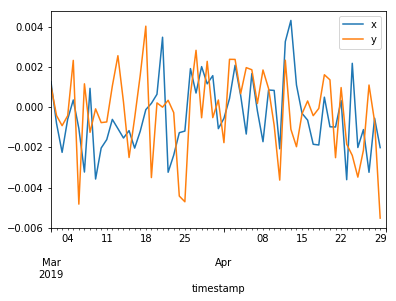

In [12]:
df[['x', 'y']].resample('24h').mean().compute().plot()

In [13]:
df[['x', 'y']].rolling(window='24h').mean().head()

,x,y
timestamp,,
2019-03-01 00:00:00,0.59,0.26
2019-03-01 00:00:01,0.71,-0.11
2019-03-01 00:00:02,0.52,-0.25
2019-03-01 00:00:03,0.16,-0.23
2019-03-01 00:00:04,0.06,-0.21


In [14]:
df.loc['2019-04-05']

,id,name,x,y
npartitions=1,,,,
2019-04-05 00:00:00.000000000,int64,object,float64,float64
2019-04-05 23:59:59.999999999,...,...,...,...


In [15]:
%time df.loc['2019-04-05'].compute()

CPU times: user 47.5 ms, sys: 21.1 ms, total: 68.6 ms
Wall time: 225 ms


,id,name,x,y
timestamp,,,,
2019-04-05 00:00:00,1049,Jerry,0.02,-0.29
2019-04-05 00:00:01,1063,Michael,-0.94,0.21
2019-04-05 00:00:02,967,Kevin,-0.17,-0.86
2019-04-05 00:00:03,998,Alice,0.63,0.87
2019-04-05 00:00:04,969,Yvonne,0.55,0.78
...,...,...,...,...
2019-04-05 23:59:55,968,Frank,-0.73,-0.47
2019-04-05 23:59:56,1037,Patricia,0.26,0.92
2019-04-05 23:59:57,961,Quinn,-0.37,-0.42


### Set Index
Data is sorted by the index column. 
This allows for faster access, joins, groupby-apply operations, etc.. However sorting data can be costly to do in parallel, so setting the index is both important to do, but only infrequently.

In [16]:
df = df.set_index('name')
df

,id,x,y
npartitions=60,,,
Alice,int64,float64,float64
Alice,...,...,...
...,...,...,...
Zelda,...,...,...
Zelda,...,...,...


Again, because computing this dataset is expensive and we can fit it in our available RAM, we persist the dataset to memory.

In [17]:
df = df.persist()

Dask now knows where all data lives, indexed cleanly by name. 
As a result operations like random access are cheap and efficient

In [18]:
%time df.loc['Alice'].compute()

CPU times: user 1.4 s, sys: 77.5 ms, total: 1.47 s
Wall time: 5.32 s


,id,x,y
name,,,
Alice,1055,0.05,0.59
Alice,1012,-0.72,0.51
Alice,1038,-0.74,-0.03
Alice,1032,-0.98,-0.12
Alice,1002,0.09,0.76
...,...,...,...
Alice,1040,-0.99,0.82
Alice,994,0.84,-0.62
Alice,1012,-0.92,-0.59


### Groupby-Apply a simple way to work on large datasets
Now that our data is sorted by name we can easily do operations like random access on name, or groupby-apply with custom functions.

Here we train a different Scikit-Learn linear regression model on each name.

In [19]:
from  sklearn.linear_model import LinearRegression

def train(partition):
    est = LinearRegression()
    est.fit(partition[['x']].values, partition.y.values)
    return est

df.groupby('name').apply(train, meta=object).compute()

name
Alice      LinearRegression(copy_X=True, fit_intercept=Tr...
Bob        LinearRegression(copy_X=True, fit_intercept=Tr...
Charlie    LinearRegression(copy_X=True, fit_intercept=Tr...
Dan        LinearRegression(copy_X=True, fit_intercept=Tr...
Edith      LinearRegression(copy_X=True, fit_intercept=Tr...
                                 ...                        
Victor     LinearRegression(copy_X=True, fit_intercept=Tr...
Wendy      LinearRegression(copy_X=True, fit_intercept=Tr...
Xavier     LinearRegression(copy_X=True, fit_intercept=Tr...
Yvonne     LinearRegression(copy_X=True, fit_intercept=Tr...
Zelda      LinearRegression(copy_X=True, fit_intercept=Tr...
Length: 26, dtype: object